In [1]:
# ------------------------------------------------
# Script for tinkering and development
# Full name: 2d_revised_radial_grid_reflecting_analysis
# ("2d disk" in the paper)
# ------------------------------------------------

using StatsBase
using Distributions
using SpecialFunctions
using Plots

default(margin=6Plots.mm) # plot parameters

In [2]:
# Input parameters
# ------------------------------------------------

const BURN_IN_GEN_N = 1000
const TOTAL_GEN_N = 1500

# Max coordinates of the population bounding space
# (population = disk)
const R_MAX_BURN_IN = 3
const R_MAX = 100

const X_MAX = R_MAX
const Y_MAX = R_MAX
const X_START = R_MAX_BURN_IN
const Y_START = R_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = 2*X_MAX+1
const Y_DIM = 2*Y_MAX+1

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.9
const S_SELECT_COEF = 0.005

0.005

In [3]:
# Data loading
# ------------------------------------------------

using Serialization
const N_IN_BATCH = 2 # The number used in the paper is 15. Due to limitations in the file size, we have only provided 2 here

padding = zeros(Float32,X_DIM,Y_DIM,BURN_IN_GEN_N)
meanfitness_set_noburn = [cat(padding,deserialize("../data/2d_radial/rrs_gridrefl_lat_noburn_$i-meanf.dat")[:,:,1:(TOTAL_GEN_N-BURN_IN_GEN_N)],dims=3) for i in 1:N_IN_BATCH] #rrs_gridrefl_noburn_
meanfitness_set = [deserialize("../data/2d_radial/rrs_gridrefl_lat_$i-meanf.dat") for i in 1:N_IN_BATCH] #rrs_gridrefl_

2-element Vector{Array{Float32, 3}}:
 [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; … ;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0]
 [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0;;; … ;;; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 

In [4]:
# Functions pertaining to the expansion front
# ------------------------------------------------

# Normalises the meanfitness matrix using the 1st method (after BURN_IN_GEN, divide by the maximum of each generation)
function normalise_all_by_maximum(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,:,BURN_IN_GEN_N+j])
        normal_array[:,:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

# Normalises the meanfitness matrix using the 3rd method (after BURN_IN_GEN, divide by the constant value of average fitness over all demes at BURN_IN_GEN_N+1)
function normalise_all_by_onset_mean(meanfit_array,offs=0)
    normal_array = copy(meanfit_array)

    sum = 0
    count = 0
    for u in meanfit_array[:,:,BURN_IN_GEN_N+1+offs]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_average = sum/count

    normal_array[:,:,BURN_IN_GEN_N+1:end] /= gen_average
    return normal_array
end

function find_front(meanfit_array,oneside=false)
    front_array = Array{Float64}(undef,0)
    for j in 1:TOTAL_GEN_N
        sum_total = 0
        cnt = 0
        # scanning every y: side 1
        for _y in 1:Y_DIM
            frontier_x = X_DIM
            while frontier_x != 1 && meanfit_array[frontier_x,_y,j] < 0
                frontier_x -= 1
            end
            if meanfit_array[frontier_x,_y,j]>0
                sum_total += meanfit_array[frontier_x,_y,j]
                cnt += 1
            end
        end
        # scanning every y: side 2
        if !oneside
            for _y in 1:Y_DIM
                frontier_x = 1
                while frontier_x != X_DIM && meanfit_array[frontier_x,_y,j] < 0
                    frontier_x += 1
                end
                if meanfit_array[frontier_x,_y,j]>0
                    sum_total += meanfit_array[frontier_x,_y,j]
                    cnt += 1
                end
            end
        end
        mean_both_sides_y = sum_total/cnt

        if !oneside
            sum_total = 0
            cnt = 0
            # scanning every x: side 1
            for _x in 1:X_DIM
                frontier_y = Y_DIM
                while frontier_y != 1 && meanfit_array[_x,frontier_y,j] < 0
                    frontier_y -= 1
                end
                if meanfit_array[_x,frontier_y,j]>0
                    sum_total += meanfit_array[_x,frontier_y,j]
                    cnt += 1
                end
            end
            # scanning every x: side 2
            for _x in 1:X_DIM
                frontier_y = 1
                while frontier_y != Y_DIM && meanfit_array[_x,frontier_y,j] < 0
                    frontier_y += 1
                end
                if meanfit_array[_x,frontier_y,j]>0
                    sum_total += meanfit_array[_x,frontier_y,j]
                    cnt += 1
                end
            end
            mean_both_sides_x = sum_total/cnt
            front_array = cat(front_array,(mean_both_sides_x+mean_both_sides_y)/2, dims=1)
        else
            front_array = cat(front_array,mean_both_sides_y, dims=1)
        end
    end
    return front_array
end

function find_front_array(meanfit_array,oneside=false)
    front_array = zeros(X_DIM,Y_DIM,TOTAL_GEN_N)
    for j in 1:TOTAL_GEN_N
        # scanning every y: side 1
        for _y in 1:Y_DIM
            frontier_x = X_DIM
            while frontier_x != 1 && meanfit_array[frontier_x,_y,j] < 0
                frontier_x -= 1
            end
            if meanfit_array[frontier_x,_y,j]>0
                front_array[frontier_x,_y,j]=meanfit_array[frontier_x,_y,j]
            end
        end
        # scanning every y: side 2
        if !oneside
            for _y in 1:Y_DIM
                frontier_x = 1
                while frontier_x != X_DIM && meanfit_array[frontier_x,_y,j] < 0
                    frontier_x += 1
                end
                if meanfit_array[frontier_x,_y,j]>0
                    front_array[frontier_x,_y,j]=meanfit_array[frontier_x,_y,j]
                end
            end
        end

        if !oneside
            sum_total = 0
            cnt = 0
            # scanning every x: side 1
            for _x in 1:X_DIM
                frontier_y = Y_DIM
                while frontier_y != 1 && meanfit_array[_x,frontier_y,j] < 0
                    frontier_y -= 1
                end
                if meanfit_array[_x,frontier_y,j]>0
                    front_array[_x,frontier_y,j]=meanfit_array[_x,frontier_y,j]
                end
            end
            # scanning every x: side 2
            for _x in 1:X_DIM
                frontier_y = 1
                while frontier_y != Y_DIM && meanfit_array[_x,frontier_y,j] < 0
                    frontier_y += 1
                end
                if meanfit_array[_x,frontier_y,j]>0
                    front_array[_x,frontier_y,j]=meanfit_array[_x,frontier_y,j]
                end
            end
        end
    end
    return front_array
end

function normalise_front_by_onset_mean(average_1d_array)
    normal_array = copy(average_1d_array)
    normal_array[BURN_IN_GEN_N+1:end] /= average_1d_array[BURN_IN_GEN_N+1]
    return normal_array
end

function normalise_front_by_max(average_1d_array,meanf_array)
    normal_array = copy(average_1d_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanf_array[:,:,BURN_IN_GEN_N+j])
        normal_array[BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

normalise_front_by_max (generic function with 1 method)

In [6]:
# No burn-in
mf_front_set_noburn = [find_front(k) for k in meanfitness_set_noburn]
mf_front_matrix_noburn = reduce(hcat,mf_front_set_noburn)'
mf_front_average_noburn = [mean(mf_front_matrix_noburn[:,i]) for i in 1:TOTAL_GEN_N]

1500-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
   0.8401709496974945
   0.8400007486343384
   0.8399169743061066
   0.8397537767887115
   0.8393781781196594
   0.8392060995101929
   0.8391380310058594
   0.8390056490898132
   0.8386257588863373

In [7]:
# Normalisation algorithm (order) I
# ------------------------------------------------

# Onset mean normalisation
mf_norm_set2 = [normalise_all_by_onset_mean(k) for k in meanfitness_set]
mf_front_norm_set2 = [find_front(k) for k in mf_norm_set2]
mf_front_norm_matrix2 = reduce(hcat,mf_front_norm_set2)'
mf_front_norm_average2 = [mean(mf_front_norm_matrix2[:,i]) for i in 1:TOTAL_GEN_N]

1500-element Vector{Float64}:
 1.0
 0.999782383441925
 0.9992130398750305
 0.9986091554164886
 0.998316764831543
 0.9981217980384827
 0.9978326559066772
 0.9974871575832367
 0.9971882700920105
 0.9966301321983337
 ⋮
 0.8258043229579926
 0.8257106840610504
 0.8255201578140259
 0.8253109455108643
 0.8252149224281311
 0.8250644207000732
 0.8248613774776459
 0.8247317969799042
 0.8244043290615082

In [8]:
# Normalisation algorithm (order) II
# ------------------------------------------------

# Onset mean normalisation
mf_front_set = [find_front(meanfitness_set[i]) for i in 1:N_IN_BATCH]
mf_front_matrix = reduce(hcat,mf_front_set)'
mf_front_average = [mean(mf_front_matrix[:,i]) for i in 1:TOTAL_GEN_N]
mf_front_average_then_norm2 = normalise_front_by_onset_mean(mf_front_average)

# Max normalisation
mf_front_norm_set1 = [normalise_front_by_max(mf_front_set[i],meanfitness_set[i]) for i in 1:N_IN_BATCH]
mf_front_norm_matrix1 = reduce(hcat,mf_front_norm_set1)'
mf_front_norm_average1 = [mean(mf_front_norm_matrix1[:,i]) for i in 1:TOTAL_GEN_N]

1500-element Vector{Float64}:
 1.0
 0.999782383441925
 0.9992130398750305
 0.9986091554164886
 0.998316764831543
 0.9981217980384827
 0.9978326559066772
 0.9974871575832367
 0.9971882700920105
 0.9966301321983337
 ⋮
 0.6068400208000998
 0.605564575887455
 0.6063768821399411
 0.6048321965654515
 0.6049211736127891
 0.6014545231360113
 0.6001403476688396
 0.5982782074955764
 0.5977291425096949

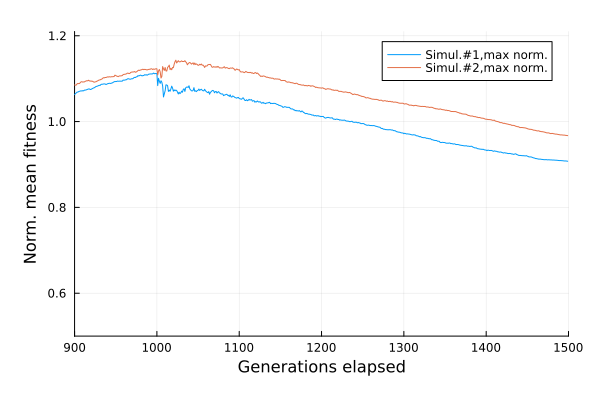

In [9]:
# Plot to check all simulation iterates
# ------------------------------------------------

p = plot(mf_front_set[1][2:end],label = "Simul.#1,max norm.",xlims=(BURN_IN_GEN_N-100,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.5,1.21))

for i in 2:N_IN_BATCH
    p = plot!(mf_front_set[i][2:end],label = "Simul.#$i,max norm.",xlims=(BURN_IN_GEN_N-100,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",ylims=(0.5,1.21))
end
display(p)

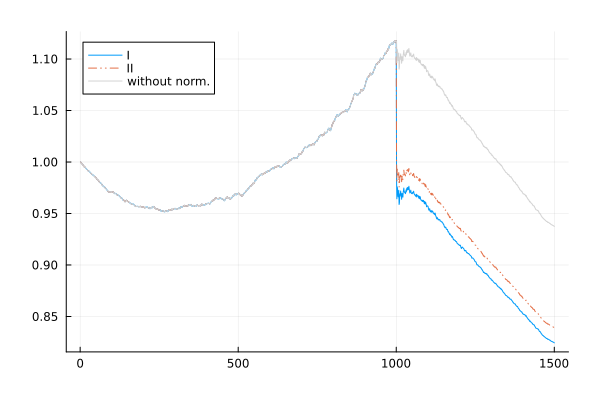

In [10]:
# Compare normalisation orders I & II
# ------------------------------------------------

plot(mf_front_norm_average2,label="I")
plot!(mf_front_average_then_norm2,label="II",linestyle=:dashdotdot)
plot!(mf_front_average,label="without norm.",color=:lightgrey)

In [11]:
# Proof that norm. algorithm II starts with 1.0 (BURN_IN_GEN_N+1)
#mf_front_average_then_norm[BURN_IN_GEN_N:end]

In [12]:
# Analytical function definitions
# ------------------------------------------------

function N_t(m,r,K,t)
    x_ = (m/2)*K*exp(r*t)
    if x_ >= K
        x_ =  K
    end
    return x_
end

function growth_T(m,r)
    return log(2/m)/r
end

function s_e(s,m,r)
    return s*(m/2)*growth_T(m,r)
end

function x0(s,m,r,K,t)
    x_ = exp(s*(growth_T(m,r)-t))
    x_ /= (exp(s*(growth_T(m,r)-t))+2*N_t(m,r,K,t)-1)
    return x_
end

function u_p_cubic(P,s,m,r,K)
    local myexp = exp(s*growth_T(m,r))
    
    return (3*myexp*(myexp-1)*P-K*m*((myexp-1)*P+1)^3+K*m)/(3*myexp*(myexp-1)-K*m*myexp^3+K*m)
end

h2(s,m,r,K) = sqrt(exp(-s*growth_T(m,r))*K*m) # A* in my PDF
h1(s,m,r) = expm1(s*growth_T(m,r)) # B in my PDF

function u_p(P,s,m,r,K)
    local myh1 = h1(s,m,r)
    local myh2 = h2(s,m,r,K)
    u_ = erf(myh1*myh2*P+myh2)-erf(myh2)
    u_ /= erf(myh1*myh2+myh2)-erf(myh2)
    return u_
end

function u_p_peischl(P,s,m,r,K)
    local mys_e = s_e(s,m,r)
    u_ = expm1(-4*mys_e*K_CAPACITY*P)
    u_ /= expm1(-4*mys_e*K_CAPACITY)
    return u_
end

#= function u_p_alt(P,s,m,r,K)
    myA = s*growth_T(m,r)
    myB = 2/K/m
    u_1 = (-1+0im)^myB * _₂F₁(1,myB,2+myB,1-exp(myA))
    u_ = u_1 / ((P-1+0im)^(1+myB) * exp(-myB*myA) * _₂F₁(myB,1+myB,2+myB,(exp(-myA)-1)*(P-1)) + u_1)
    return u_
end =#
function u_p_alt(P,s,m,r,K)
    myA = expm1(s*growth_T(m,r))
    myB = 2/K/m + 1
    u_ = ((myA*P+1)^myB - 1)/((myA+1)^myB - 1)
    return u_
end

u_p_alt (generic function with 1 method)

In [13]:
LOCI_N_THEORY = LOCI_N

function large_p(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function large_p_test(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),s,m,r,K)
    return P_
end
function large_p_test2(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function mu_effect(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test2(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end

function large_p_2015(s,migr,r,K,mut)
    my_4seK = 4*s_e(s,migr,r)*K
    P_ = -mut*my_4seK/expm1(-my_4seK)
    return P_
end
function mu_effect_2015(t)
    mu_ = 2*S_SELECT_COEF*(1-MUT_DELETER_RATE)*large_p_2015(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    mu_ -= 2*S_SELECT_COEF*MUT_DELETER_RATE*large_p_2015(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    return mu_
end

mu_effect_2015 (generic function with 1 method)

In [14]:
# Calculate the analytical approximation
# ------------------------------------------------

using QuadGK

function find_mf_theory(start_mf;mu_func=mu_effect)
    my_T = growth_T(M_MIG_RATE,r_LOG_PROLIF_RATE)
    sim_inte_result = quadgk(mu_func,0,my_T)[1]/my_T

    mean_fitness_sim_result = Array{Float64}(undef,0)

    for t_i in 1:BURN_IN_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,0,dims=1)
    end

    mean_fitness_sim_result = cat(mean_fitness_sim_result,start_mf, dims=1)

    for t_i in (BURN_IN_GEN_N+2):TOTAL_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,mean_fitness_sim_result[t_i-1]*(1+sim_inte_result)^LOCI_N_THEORY, dims=1)
    end
    return mean_fitness_sim_result
end

find_mf_theory (generic function with 1 method)

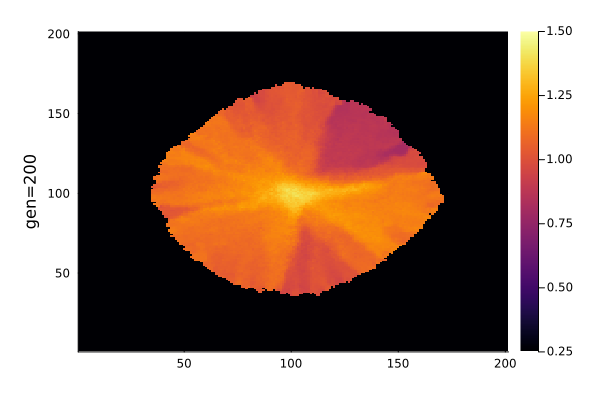

In [16]:
# Graph absolute fitness (sample)
# ------------------------------------------------

heatmap(meanfitness_set[2][:,:,1300]',clims=(0.25,1.5),ylabel="gen=200")

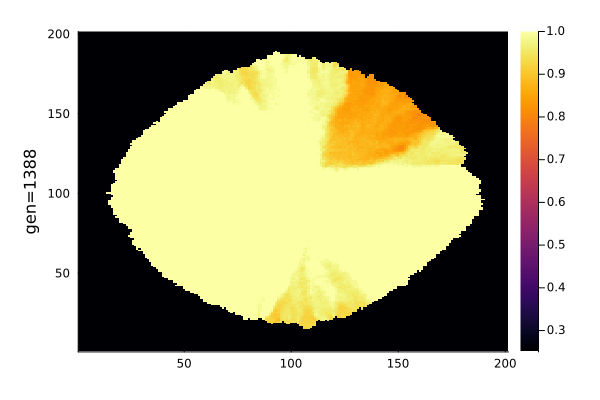

In [17]:
heatmap(meanfitness_set[2][:,:,1388]',clims=(0.25,1.0),ylabel="gen=1388")

In [18]:
#= plot(mf_front_average2[BURN_IN_GEN_N+1:end],label = "This study",xlabel="Generations elapsed",ylabel="Mean fitness",linestyle=:dashdotdot,xlims=(0,500))
plot!(mf_front_average_then_norm2[BURN_IN_GEN_N+1:end],label = "This study (onset mean normalisation)",xlabel="Generations elapsed",ylabel="Mean fitness",color="dodgerblue")
plot!(mf_front_norm_average2[BURN_IN_GEN_N+1:end],label = "This study (onset mean normalisation I)",xlabel="Generations elapsed",ylims=(0.75,1.25))
plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],color="blue",label = "This study (no burn-in)")
plot!(find_mf_theory(1;mu_func=mu_effect_test2)[BURN_IN_GEN_N+1:end],label = "1D analytic approximation",color="green",linestyle=:dash)
vline!([355],style=:dash,color=:gray,label=:none) =#

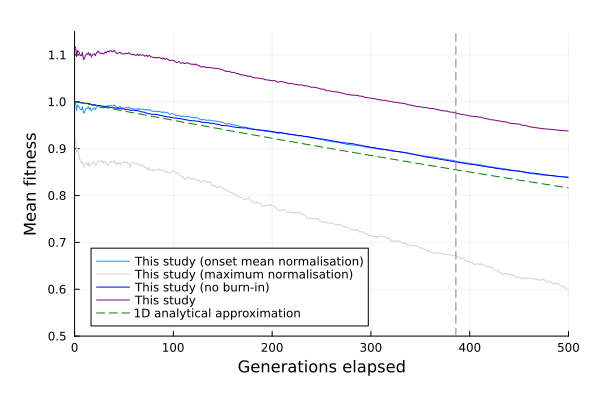

In [19]:
plot(mf_front_average_then_norm2[BURN_IN_GEN_N+1:end],color="dodgerblue",label = "This study (onset mean normalisation)",xlims=(0,500),xlabel="Generations elapsed",ylabel="Mean fitness")
plot!(mf_front_norm_average1[BURN_IN_GEN_N+1:end],label = "This study (maximum normalisation)",color="lightgrey")
plot!(mf_front_average_noburn[BURN_IN_GEN_N+1:end],label = "This study (no burn-in)",color="blue")
plot!(mf_front_average[BURN_IN_GEN_N+1:end],label = "This study",color="purple")
plot!(find_mf_theory(1;mu_func=mu_effect_test2)[BURN_IN_GEN_N+1:end],label = "1D analytical approximation",linestyle=:dash,color="green",ylims=(0.5,1.15))
vline!([386],style=:dash,color=:gray,label=:none)